In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [83]:
train = pd.read_csv('train.csv', parse_dates = ['PERIOD','TRDATETIME'])

In [13]:
test =  pd.read_csv('test.csv', parse_dates = ['PERIOD','TRDATETIME'])

In [5]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,2017-01-12,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,2017-01-10,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,2017-01-10,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [15]:
test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,2017-01-04,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,2017-01-03,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,2017-01-02,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,2017-01-04,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,2017-01-04,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


In [200]:
tmp = test[test['amount']>1000000]
#tmp['trx_category'].value_counts()

In [202]:
#tmp.sort_values('amount', ascending=False)

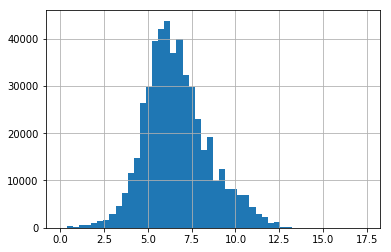

In [194]:
np.log(train['amount']+1).hist(bins=50);

In [31]:
#np.log(test['amount'] + 1).hist(bins=50);

Outliyers!

In [33]:
train['channel_type'].value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

In [36]:
train['trx_category'].value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

In [39]:
len(np.unique(train['cl_id']))

5000

In [44]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,2017-01-12,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,2017-01-10,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,2017-01-10,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [69]:
tmp = pd.DataFrame( data = train[['cl_id', 'target_sum']].groupby(['cl_id']).agg(['max', 'min']).values,
                    columns = ['max', 'min'])
tmp = tmp.assign( diff = np.abs(tmp['max'] - tmp['min']))
tmp.sort_values(by = ['diff'], ascending=False, inplace=True)
print(tmp.head(), "\n")
print(tmp.shape[0])

          max      min  diff
0        0.00     0.00   0.0
3330  1188.34  1188.34   0.0
3337     0.00     0.00   0.0
3336     0.00     0.00   0.0
3335     0.00     0.00   0.0 

5000


In [109]:
#train[['cl_id', 'target_flag']].groupby(['cl_id']).agg(['max', 'min'])

In [75]:
tmp = pd.DataFrame( data = train[['cl_id', 'target_flag']].groupby(['cl_id']).agg(['max', 'min']).values,
                    columns = ['max', 'min'])
tmp = tmp.assign( diff = np.abs(tmp['max'] - tmp['min']))
tmp.sort_values(by = ['diff'], ascending=False, inplace=True)
print(tmp.head(), "\n")
print(tmp.shape[0])

      max  min  diff
0       0    0     0
3330    1    1     0
3337    0    0     0
3336    0    0     0
3335    0    0     0 

5000


In [73]:
print(train.shape)
print(test.shape, "\n")
print(len(np.unique(train['cl_id'])))
print(len(np.unique(test['cl_id'])))

(490513, 10)
(518376, 8) 

5000
5217


In [ ]:
# target для всех клиентов одинаковый, это хорошо

In [78]:
print( set(train['cl_id']).intersection(set(test['cl_id'])) )

set()


In [85]:
train['PERIOD_1'] = pd.to_datetime(train['PERIOD'], format='%d/%m/%Y')

In [86]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,PERIOD_1
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,2017-10-01
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,2017-10-01
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,2017-12-01
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,2017-10-01
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2017-10-01


In [82]:
print( type(train['PERIOD'].values[0]))
print( type(train['PERIOD_1'].values[0]))

<class 'numpy.datetime64'>
<class 'numpy.datetime64'>


In [ ]:
train.groupby(['cl_id']).['amount'].agg(['max','mean' , 'std','min']).values,
                    columns = ['max', 'min'])

In [ ]:
field = 'currency'
id_field = 'cl_id'


In [93]:
func_list = ['sum', 'std', 'max', 'min', 'count']
field = 'currency'

[ field + '_' + f for  f in func_list]

['currency_sum',
 'currency_std',
 'currency_max',
 'currency_min',
 'currency_count']

In [ ]:
train = train.assign(year = pd.DatetimeIndex(train['PERIOD_1']).year.values, 
                     month = pd.DatetimeIndex(train['PERIOD_1']).month.values,
                     day =   train['TRDATETIME'].apply(lambda x: x[:2]))

train = train.assign( txn_dt = 
                     pd.to_datetime(train['year'].astype(str) + '-' \
                                    + train['month'].astype(str) + '-' + train['day'].astype(str)))
train.drop(['year', 'month', 'day'], axis=1, inplace=True)

In [203]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,PERIOD_1,txn_dt
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,2017-10-01,2017-10-21
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,2017-10-01,2017-10-12
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,2017-12-01,2017-12-05
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,2017-10-01,2017-10-21
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,2017-10-01,2017-10-24


In [210]:
a = pd.DataFrame(train['cl_id'].unique())

In [230]:
# list of fields to group by :
#group_by_fields = ['MCC', 'channel_type', 'currency', 'trx_category']
# add window_list:
# START_DATE 
# window_list = [30, 90, 180, all]
def get_aggr_feat(df,  group_by_fields, 
                 id_field = 'cl_id', 
                 value = 'amount', 
                 func_list = ['sum', 'std', 'max', 'min', 'count']):
    
    df_out =  pd.DataFrame(df[id_field].unique())
    
    for field in group_by_fields:
        df_tmp = pd.DataFrame( data = df.groupby([id_field, field])[value].agg(func_list).values,
                               columns = [ field + '_' + f for  f in func_list]).reset_index()
        df_tmp = df_tmp.drop(field, axis=1, inplace=False)
        df_out = df_out.join(df_tmp, on = id_field, how='left') 
        
    return df_out
        # add date window aggr 
        # add count didtinct values

In [266]:
df=train
group_by_fields = ['MCC', 'channel_type', 'currency', 'trx_category']
id_field = 'cl_id'
value = 'amount'
func_list = ['sum', 'std', 'max', 'min', 'count']

In [267]:
df_tmp = pd.DataFrame( data = df.groupby([id_field, field])[value].agg(func_list).values,
                               columns = [ field + '_' + f for  f in func_list]).reset_index()

In [268]:
df_tmp.head()

,index,currency_sum,currency_std,currency_max,currency_min,currency_count
0,0,64383.00,15310.857954,36562.00,767.0,5.0
1,1,266693.13,11949.074895,60000.00,76.0,70.0
2,2,884.91,16.279815,83.90,3.0,34.0
3,3,1442.67,268.846794,605.17,107.0,4.0
4,4,544874.63,7549.799078,56164.05,75.0,136.0


In [261]:
field = 'currency'
cols = [ field + '_' + f for  f in func_list]

In [262]:
cols

['currency_sum',
 'currency_std',
 'currency_max',
 'currency_min',
 'currency_count']

In [259]:
tmp.head()

sum           std       max    min  count
cl_id currency                                                 
0     810        64383.00  15310.857954  36562.00  767.0      5
1     810       266693.13  11949.074895  60000.00   76.0     70
      978          884.91     16.279815     83.90    3.0     34
5     504         1442.67    268.846794    605.17  107.0      4
      810       544874.63   7549.799078  56164.05   75.0    136

In [222]:
df_out =  pd.DataFrame(train[id_field].unique())

In [251]:
tmp = get_aggr_feat( df=train, 
                     group_by_fields = ['MCC', 'channel_type', 'currency', 'trx_category'],
                     id_field = 'cl_id',
                     value = 'amount', 
                     func_list = ['sum', 'std', 'max', 'min', 'count'])

In [252]:
f = 'trx_category'
tmp = tmp.reset_index() 
tmp = tmp.drop(f, axis=1, inplace=False)

In [256]:
tmp.head()

,cl_id,trx_category_sum,trx_category_std,trx_category_max,trx_category_min,trx_category_count
0,0,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN
